In [1]:
!pip install pmdarima xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.0/698.0 kB 22.8 MB/s eta 0:00:00


In [2]:
file_name = "/kaggle/input/us-gasoline-and-diesel-retail-prices-19952021/PET_PRI_GND_DCUS_NUS_W.csv"

try:
    with open(file_name, 'r') as file:
        content = file.read()
        print(f"✅ File read successfully. Content length: {len(content)} bytes.")
except FileNotFoundError:
    print(f"❌ File not found at the expected path: '{file_name}'.")

✅ File read successfully. Content length: 119283 bytes.


In [3]:
# --- 0. INSTALL AND IMPORT LIBRARIES ---
# Run this in a separate cell if not installed:
# 
# ----------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
import os # Used to handle Kaggle's file paths

In [4]:
# --- 1. DATA LOADING AND CLEANING ---
# ------------------------------------

# --- A. Load Gas Price Data (Weekly) ---
# TARGET (Y): We will use the R1 column (Regular All Formulations)
GAS_PRICE_PATH = '/kaggle/input/us-gasoline-and-diesel-retail-prices-19952021/PET_PRI_GND_DCUS_NUS_W.csv'
df_gas = pd.read_csv(GAS_PRICE_PATH)

# Clean and set index
df_gas.rename(columns={'R1': 'gas_price', 'Date': 'date'}, inplace=True)
df_gas = df_gas[['date', 'gas_price']]
df_gas['date'] = pd.to_datetime(df_gas['date'], format='%m/%d/%Y') # Handle date format
df_gas.set_index('date', inplace=True)
df_gas.sort_index(inplace=True)

# --- B. Load Crude Oil Data (Daily) ---
# EXOGENOUS (X): We will use the '# close' price from your WTI data.
CRUDE_PRICE_PATH = '/kaggle/input/historical-crude-oil-futures-prices-wti-and-brent/wti_prices.csv' # Use your actual path
df_crude = pd.read_csv(CRUDE_PRICE_PATH)


# Convert the 'crude_price' column to numeric
# The 'errors=coerce' handles any non-numeric headers or bad data by turning them into NaN
df_crude['close'] = pd.to_numeric(df_crude['close'], errors='coerce')

# Filter and set index
df_crude = df_crude[['date', 'close']]
df_crude['date'] = pd.to_datetime(df_crude['date'])
df_crude.set_index('date', inplace=True)
df_crude.sort_index(inplace=True)
df_crude.dropna(subset=['close'], inplace=True) 
print("DONE")

DONE


In [5]:
# --- 2. DATA MERGING AND ALIGNMENT ---
# -------------------------------------

# Resample Daily Crude Prices to Weekly Average (to match Gas Prices)
df_crude_weekly = df_crude['close'].resample('W-MON').mean().to_frame() # W-MON aligns with EIA data frequency

# Merge the two datasets on the date index
df_merged = df_gas.merge(
    df_crude_weekly, 
    left_index=True, 
    right_index=True, 
    how='inner' # Only keep dates present in both datasets
)

# Handle potential missing values (often caused by holidays/mismatches)
df_merged.fillna(method='ffill', inplace=True) # Forward fill missing values
df_merged.dropna(inplace=True) # Drop any remaining NaNs

# Final Clean Data Check
print(f"Final Merged Data Shape: {df_merged.shape}")
print(df_merged.head())

# =========================================================================
# === MODEL PREPARATION AND SPLITTING ===
# =========================================================================

# Split data (80% train, 20% test - time-aware split)
train_size = int(len(df_merged) * 0.8)
train_df = df_merged.iloc[:train_size]
test_df = df_merged.iloc[train_size:]

Final Merged Data Shape: (218, 2)
            gas_price      close
date                            
2016-11-28      2.154  57.943333
2016-12-05      2.208  58.088000
2016-12-12      2.236  58.056000
2016-12-19      2.264  57.150000
2016-12-26      2.309  57.225000


/tmp/ipykernel_48/759514034.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged.fillna(method='ffill', inplace=True) # Forward fill missing values


In [6]:
# --- 3. FEATURE ENGINEERING FOR XGBOOST ---
# ------------------------------------------

def create_xgb_features(df):
    """Creates time-based and lagged features for the XGBoost model."""
    # Time Features (Capturing seasonality and trend)
    df['dayofyear'] = df.index.dayofyear
    df['month'] = df.index.month
    df['year'] = df.index.year

    # Lagged Features (Crucial for time series)
    # Gas Price: Use previous week's price (t-1)
    df['gas_price_lag1'] = df['gas_price'].shift(1)
    
    # Crude Price: Use lagged Crude Price (e.g., 4 weeks ago) as a predictor
    df['crude_price_lag4'] = df['close'].shift(4)
    
    return df.dropna()

train_features = create_xgb_features(train_df.copy())
test_features = create_xgb_features(test_df.copy())

# Define X and Y for XGBoost
X_train, y_train = train_features.drop('gas_price', axis=1), train_features['gas_price']
X_test, y_test = test_features.drop('gas_price', axis=1), test_features['gas_price']

In [7]:
# =========================================================================
# === MODEL 4: SARIMAX (Statistical Baseline) ===
# =========================================================================

# --- A. Define Endogenous (Y) and Exogenous (X) for SARIMAX ---
sarimax_train_y = train_df['gas_price']
# SARIMAX needs raw exogenous columns *before* creating lagged features
sarimax_train_X = train_df[['close']] 
sarimax_test_X = test_df[['close']]
TARGET_COL = 'gas_price'

print("\n--- Starting SARIMAX Training (Finding Parameters) ---")

# --- B. Forecast Exogenous Variables---
print("Forecasting Crude Oil prices to prevent data leakage...")
crude_model = auto_arima(
    sarimax_train_X,
    seasonal=False, # Crude oil often less seasonal than gas
    trace=False,
    error_action='ignore',
    suppress_warnings=True
)
# Forecast Crude Oil for the test period
crude_forecast = crude_model.predict(n_periods=len(test_df))
# Create a DataFrame for the forecasted exogenous variables
exog_forecast = pd.DataFrame(crude_forecast, index=test_df.index, columns=['close'])

# --- C. Parameter Selection (Use auto_arima for quick tuning) ---
# s=52 for weekly seasonality. D=1 for seasonal differencing.
sarima_model = auto_arima(
    y=sarimax_train_y,
    X=sarimax_train_X,
    m=52,                      # Seasonal period (52 weeks)
    d=1, D=1,                  # Differencing terms
    trace=False,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# --- D. Fit and Predict ---
sarimax_model = SARIMAX(
    sarimax_train_y, 
    exog=sarimax_train_X,
    order=sarima_model.order,
    seasonal_order=sarima_model.seasonal_order
)
sarimax_results = sarimax_model.fit(disp=False)

# Use the FORECASTED crude oil prices as exogenous variables
sarimax_forecast = sarimax_results.get_forecast(
    steps=len(test_df), 
    exog=exog_forecast
)

sarimax_predictions = sarimax_forecast.predicted_mean
sarimax_rmse = np.sqrt(mean_squared_error(test_df.iloc[1:][TARGET_COL], sarimax_predictions.iloc[1:])) 
print(f"SARIMAX Final RMSE: {sarimax_rmse:.4f}")


--- Starting SARIMAX Training (Finding Parameters) ---
Forecasting Crude Oil prices to prevent data leakage...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX Final RMSE: 0.2393


In [8]:

# =========================================================================
# === MODEL 5: XGBoost (Machine Learning Approach) ===
# =========================================================================

print("\n--- Starting XGBoost Training ---")

# --- A. Fit the XGBoost Model ---
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    random_state=42,
    tree_method='hist' # Change to 'gpu_hist' on Kaggle GPU for faster training
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=50,
    verbose=False
)

# --- B. Predict and Evaluate ---
xgb_predictions = xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_predictions))
print(f"XGBoost Final x: {rmse_xgb:.4f}")


--- Starting XGBoost Training ---


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBoost Final x: 0.1238



--- FINAL RESULTS COMPARISON ---
SARIMAX RMSE: 0.2393
XGBoost RMSE: 0.1238


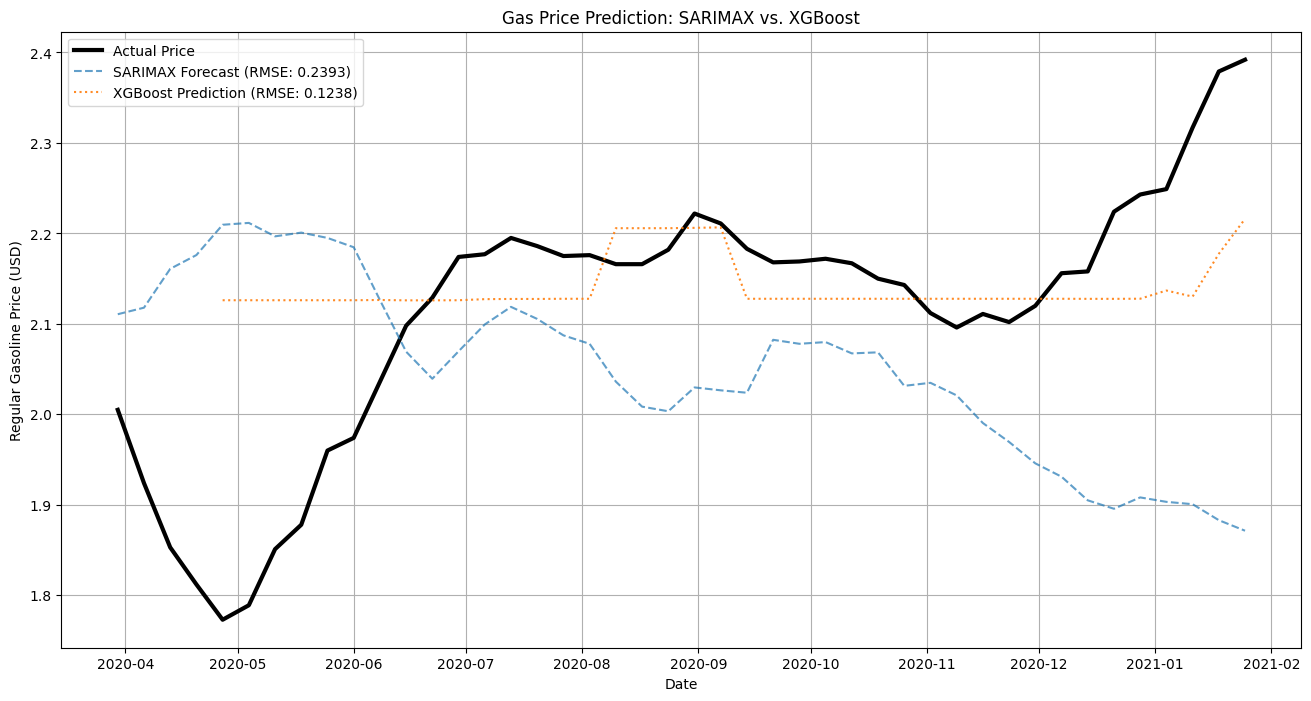

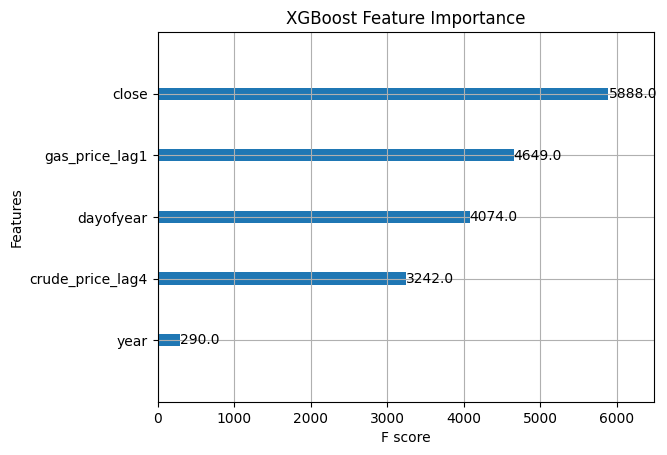

In [9]:
# =========================================================================
# === FINAL COMPARISON AND VISUALIZATION ===
# =========================================================================

print("\n--- FINAL RESULTS COMPARISON ---")
print(f"SARIMAX RMSE: {sarimax_rmse:.4f}")
print(f"XGBoost RMSE: {rmse_xgb:.4f}")

# Plotting the results
plt.figure(figsize=(16, 8))
plt.plot(df_merged.index[train_size:], test_df[TARGET_COL], label='Actual Price', color='black', linewidth=3)
plt.plot(test_df.index, sarimax_predictions, label=f'SARIMAX Forecast (RMSE: {sarimax_rmse:.4f})', linestyle='--', alpha=0.7)
plt.plot(test_df.index[len(test_df) - len(xgb_predictions):], xgb_predictions, label=f'XGBoost Prediction (RMSE: {rmse_xgb:.4f})', linestyle=':', alpha=0.9)
plt.title('Gas Price Prediction: SARIMAX vs. XGBoost')
plt.xlabel('Date')
plt.ylabel('Regular Gasoline Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Visualize Feature Importance for XGBoost
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='weight')
plt.title('XGBoost Feature Importance')
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =========================================================================
# === ADVANCED METRICS CALCULATION ===
# =========================================================================

# --- A. SARIMAX Metrics ---
sarimax_predictions = sarimax_forecast.predicted_mean
y_test_sarimax = test_df.iloc[1:][TARGET_COL] # Aligning the test set indices

sarimax_rmse = mean_squared_error(y_test_sarimax, sarimax_predictions.iloc[1:], squared=False)
sarimax_mae = mean_absolute_error(y_test_sarimax, sarimax_predictions.iloc[1:])
sarimax_r2 = r2_score(y_test_sarimax, sarimax_predictions.iloc[1:])

print("\n--- SARIMAX (SARIMA) Advanced Stats ---")
print(f"RMSE (Penalizes big errors): {sarimax_rmse:.4f}")
print(f"MAE (Avg. error in cents): {sarimax_mae:.4f}")
print(f"R-squared (Variance explained): {sarimax_r2:.4f}")

# --- B. XGBoost Metrics ---
xgb_predictions = xgb_model.predict(X_test)
y_test_xgb = y_test

xgb_rmse = mean_squared_error(y_test_xgb, xgb_predictions, squared=False)
xgb_mae = mean_absolute_error(y_test_xgb, xgb_predictions)
xgb_r2 = r2_score(y_test_xgb, xgb_predictions)

print("\n--- XGBoost Advanced Stats ---")
print(f"RMSE (Penalizes big errors): {xgb_rmse:.4f}")
print(f"MAE (Avg. error in cents): {xgb_mae:.4f}")
print(f"R-squared (Variance explained): {xgb_r2:.4f}")


--- SARIMAX (SARIMA) Advanced Stats ---
RMSE (Penalizes big errors): 0.2393
MAE (Avg. error in cents): 0.2008
R-squared (Variance explained): -1.7090

--- XGBoost Advanced Stats ---
RMSE (Penalizes big errors): 0.1238
MAE (Avg. error in cents): 0.0849
R-squared (Variance explained): 0.1230


In [16]:
import joblib
import os

# Define a directory for saved models (e.g., 'models')
os.makedirs('models', exist_ok=True) 

# --- A. Save the XGBoost Model ---
xgb_filename = 'models/xgboost_gas_model.joblib'
joblib.dump(xgb_model, xgb_filename)
print(f"XGBoost model saved to: {xgb_filename}")

# --- B. Save the SARIMAX Model ---
# Note: SARIMAX uses its own save/load format (pickle)
sarimax_filename = 'models/sarimax_gas_model34.pkl'
sarimax_results.save(sarimax_filename)
print(f"SARIMAX model saved to: {sarimax_filename}")

XGBoost model saved to: models/xgboost_gas_model.joblib
SARIMAX model saved to: models/sarimax_gas_model34.pkl
